## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import pairwise_distances
import tadasets
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
from sklearn.decomposition import PCA

## Plotting Projections Function

In [106]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], linewidth = 3)

def plotCocycle2D(D, X, cocycle, thresh):
    """
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    """
    #Plot all edges under the threshold
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    #Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
    #Plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

## Warm Up (5%)

For this part of the homework, we are only trying to understand the example given in the Ripser site and apply the same code to a different set of sampled points, which looks like the first figure below.
The Ripser function, in this case, takes as argument the set of data points that we have sampled, and gives us the following things. First, it gives us the distance matrix, i.e. all the point-wise distances among all the data points. Furthermore, we get the representative cocycles, which have the form of an array of sets [point 1, point 2, value of the edge], and finally, the diagrams, which tell us the birth and death of each feature. The persistence diagram we get from the implementation is depicted in the figures below.

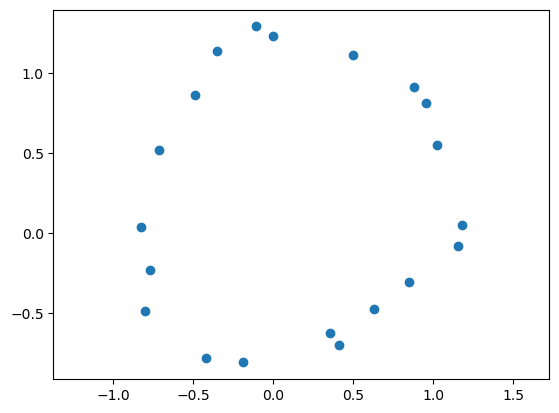

In [108]:
#SAMPLING AND PLOTTING OF POINTS
N=20
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)]) + 0.4*np.random.random((N,2))
plt.scatter(x[:,0],x[:,1])
plt.axis("equal")
plt.savefig("Warm_Up_Points")
plt.show()

[[0.57496953 1.64568257]]


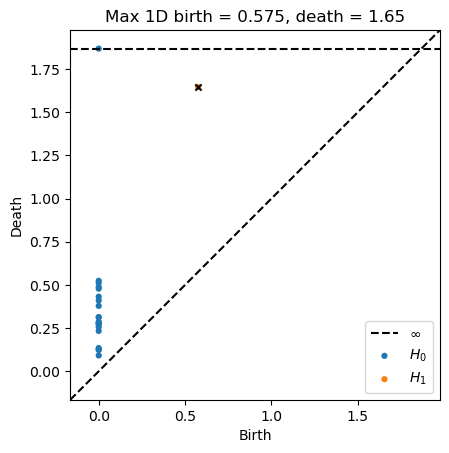

In [109]:
#RIPSER IMPLEMENTATION AND BARCODE PLOTTING

result = ripser(x, coeff=17, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']
dgm1=diagrams[1]
idx=np.argmax(dgm1[:,1]-dgm1[:,0])
print(dgm1)

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.savefig("Persistence_Diagram_Warm_Up.png")
plt.show()

From the persistence diagram we see that the in one dimension, the maximum persistent point, i.e. the longest bar is printed above. These numbers are the distance thresholds, meaning that if two points have distance smaller than that, they are connected with an edge which will be assigned the value given by the representative cocycles, that is, the projection of the cocycle on the aforementioned edge. We now want to project the cocycles onto the edges that are present right before the feature vanishes, and right after the its birth. The resulting plots are given in Figure

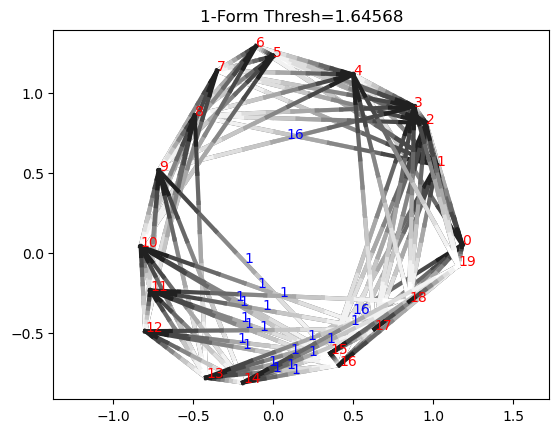

In [110]:
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 1] #Project cocycle onto edges less than or equal to death time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.savefig("Before_Death.png")
plt.show()

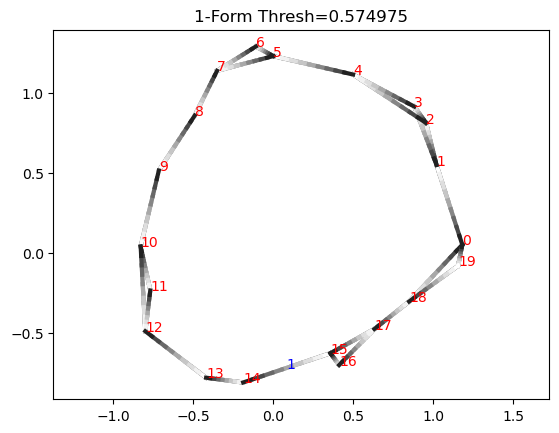

In [111]:
thresh = 1.00001*dgm1[idx, 0] #Project cocycle onto edges that have lengths less than or equal to the birth time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.savefig("After_Birth.png")
plt.show()

## Implementation (40%)

Now we follow the algorigthm given in the exercise sheet and define the circular coordinates function as follows:

In [2]:
def circular_coordinates(distances, cocycle, thresh, prime):
    
    #PROJECT COCYCLE ONTO VERTICES WITH LENGH UNDER THE THRESHOLD
    #AND THEN LIFT THE PROJECTIONS
    projections = [] #Initialize a set for the projected cocycle
    for k in range(cocycle.shape[0]):
        [i,j,val] = cocycle[k,:]
        if distances[i,j] <= thresh:
            [i,j] = [min(i,j), max(i,j)]
            #Lift the projections
            if val > (prime-1)/2:
                val = val - prime
            
            projections.append([i,j,val])
    projections = np.array(projections)
    
    #REPRESENT THE COBOUNDARY OPERATOR IN THE BASIS GIVEN BY THE SIMPLICES
    #I.E. CONNECTED VERTICES BY EDGES
    
    #First we find the connected vertices and thus, the corresponding edges
    #We initialize a matrix with the same dimensions as the distance matrix
    #and zero entries. Then we set the (i,j)th entry to 1 if the distance
    #of the two vertices is smaller than the threshold.
    connected_vertices = np.zeros((distances.shape[0],distances.shape[0]))
    for i in range(distances.shape[0]):
        for j in range(i):
            if distances[j,i] < thresh:
                connected_vertices[j,i] = 1
    v1,v2 = np.nonzero(connected_vertices)
    #Now we initialize the coboundary matrix with number of rows equal to the
    #number of connected vertices (edges) and number of columns all the vertices.
    #Then we set the ((vertex1,vertex2),vertex i) = -1 for i =1 and +1 for i =2.
    coboundary = np.zeros((v1.shape[0],distances.shape[0]))
    for i in range(v1.shape[0]):
        for j in range(distances.shape[0]):
            if j == v1[i]:
                coboundary[i,j] = -1
            elif j == v2[i]:
                coboundary[i,j] = 1
    M = coboundary
    #CALCULATE THE PSEUDOINVERSE OF THE COBOUNDARY
    M_pseudo = np.linalg.pinv(M)
    
    #CALCULATE REPRESENTATION OF THE PROJECTED COCYCLE IN THE 1-SIMPLICES BASIS
    
    b = np.zeros((coboundary.shape[0],1))
    for i in range(v1.shape[0]):
        for j in range(projections.shape[0]):
            if v1[i] == projections[j,0] and v2[i] == projections[j,1]:
                b[i] = projections[j,2]
    
    #CALCULATE THE CIRCULAR COORDINATES FOR ALL VERTICES
    circ_coords = -M_pseudo.dot(b)%1 #Matrix multiplication and then mod Z
        
    return circ_coords  

## First Example (5%)

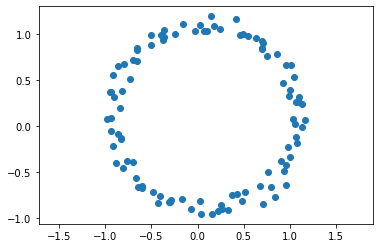

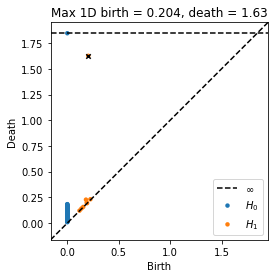

In [3]:
N=100
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)]) + 0.2*np.random.random((N,2))

plt.scatter(x[:,0],x[:,1])
plt.axis("equal")
plt.savefig("Ex2_Points.png")
plt.show()

result = ripser(x, coeff=41, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

dgm1=diagrams[1]
idx=np.argmax(dgm1[:,1]-dgm1[:,0])
#print(dgm1)

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.savefig("Persistence_Diagram_Warm_Up.png")
plt.show()

cocycle=cocycles[1][idx]
diagrams[1][idx];

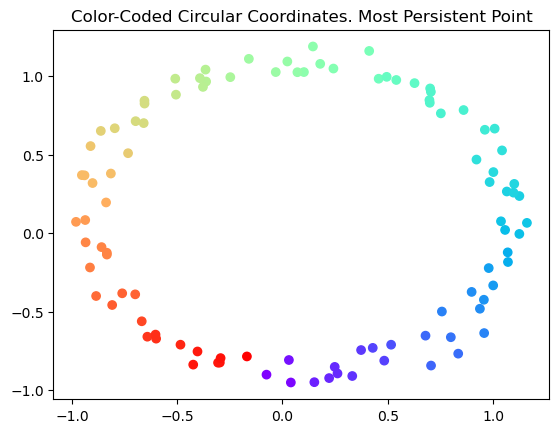

In [4]:
#CALCULATE CIRCULAR COORDINATES
thresh = 1 #Set the threshold
circ = circular_coordinates(D,cocycle,thresh, 41);

#SCATTER PLOT THE VERTICES COLORED BASED ON CIRCULAR COORDINATES
plt.scatter(x[:,0],x[:,1],c=circ,cmap='rainbow')
plt.title("Color-Coded Circular Coordinates. Most Persistent Point")
plt.savefig("Colored_Vertices.png")
plt.show()

## Flat Torus (15%)

In [5]:
def distance(point1,point2):
    x1 = point1[0]; y1 = point1[1]; x2 = point2[0]; y2 = point2[1]
    if abs(x1-x2) <= 0.5:
        dx = x1-x2
        if abs(y1-y2) <= 0.5:
            dy = y1-y2
        else:
            dy = 1 - max(y1,y2) + min(y1,y2)
    else:
        dx = 1 - max(x1,x2) + min(x1,x2)
        if abs(y1-y2) <= 0.5:
            dy = y1-y2
        else:
            dy = 1 - max(y1,y2) + min(y1,y2)
   
    return np.sqrt(dx**2 + dy**2)

def distance_matrix(points):
    row = np.zeros((X.shape[0]))
    for j in range(X.shape[0]):
        row[j] = distance(X[0],X[j])
    dist_mat = row    
    for i in range(X.shape[0]-1):
        row = np.zeros((X.shape[0]))
        for j in range(X.shape[0]):
            row[j] = distance(X[i+1],X[j])
    
        dist_mat = np.vstack((dist_mat,row))
    return dist_mat
    

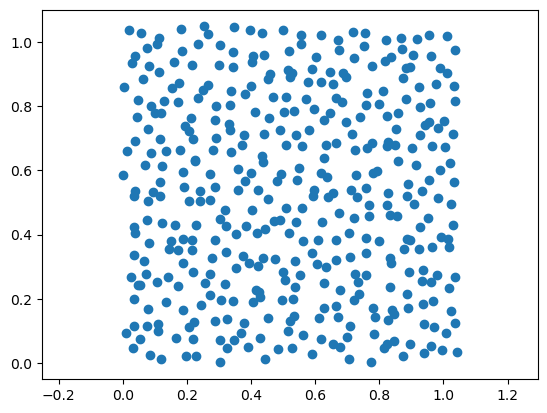

In [6]:
n=20
t = np.linspace(0,1,n)
x,y = np.meshgrid(t,t)
x = np.reshape(x, (n*n,1))
y = np.reshape(y, (n*n,1))
X = np.hstack([x, y]) + 0.05*np.random.random((n*n,2))

plt.scatter(X[:,0],X[:,1])
plt.axis("equal")
plt.savefig("Torus_Points.png")
plt.show()


In [7]:
#We call the ripser function with the distance matrix as an arguement
#because that way we "identify" the oposite sides.
D = distance_matrix(X)
result = ripser(D, coeff=41, do_cocycles=True, distance_matrix=True)
diagrams = result['dgms']
cocycles = result['cocycles']
dgm1=diagrams[1] 

     Indices     Birth     Death  Persistence
0        0.0  0.088931  0.092474     0.003543
1        1.0  0.083993  0.087810     0.003816
2        2.0  0.082655  0.087145     0.004489
3        3.0  0.080745  0.082601     0.001856
4        4.0  0.079664  0.085196     0.005532
..       ...       ...       ...          ...
138    138.0  0.049535  0.082845     0.033310
139    139.0  0.049443  0.053770     0.004327
140    140.0  0.049354  0.051054     0.001699
141    141.0  0.048984  0.051056     0.002072
142    142.0  0.048049  0.049155     0.001107

[143 rows x 4 columns]


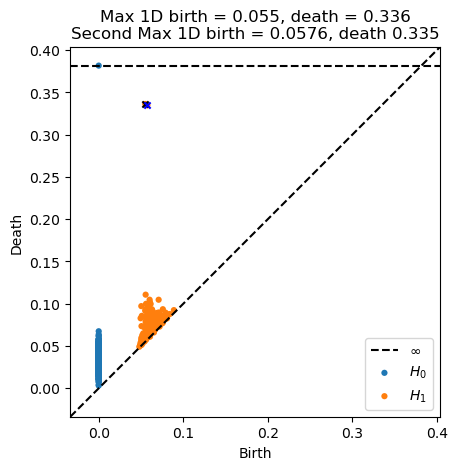

In [8]:
idx_mp = np.argmax(dgm1[:,1]-dgm1[:,0]) #Most persistent point

def pers(array):
    return (array[:,1]-array[:,0])

pers = pers(dgm1)#Apply the difference with ratio function to all points of the barcode
pers = pers.reshape((pers.shape[0],1))
indices = np.array(range(dgm1.shape[0])).reshape((dgm1.shape[0],1))
pers = np.hstack((indices,dgm1,pers))
pers = pd.DataFrame(pers, columns = ["Indices","Birth","Death","Persistence"])
print(pers)
pers = pers.sort_values(by = ["Persistence"], ascending = False)
pers = pers.to_numpy()

idx_mp = int(pers[:,0][0])
idx_smp = int(pers[:,0][1])

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx_mp, 0], dgm1[idx_mp, 1], 20, 'k', 'x') #Plots a black x on the most persistent point
plt.scatter(dgm1[idx_smp,0],dgm1[idx_smp,1],20,'b','x') #Plots a blue x on the second most persistent point
plt.title("Max 1D birth = %.3g, death = %.3g\nSecond Max 1D birth = %.3g, death %.3g"%(dgm1[idx_mp, 0], dgm1[idx_mp, 1],dgm1[idx_smp,0],dgm1[idx_smp,1]))      
plt.savefig("Persistence_Diagram_Flat_Torus.png")
plt.show()

cocycle_mp = cocycles[1][idx_mp] #We choose the most persistent cocycle
cocycle_smp = cocycles[1][idx_smp] #We choose the second most persistent cocycle

As mentioned in the comments, we have chosen a threshold such that both most persistent features are both alive at the same time.

In [9]:
#CHOOSE A THRESHOLD
#We choose a threshold such that both features that the aforementioned cocycles represent
#have been born and neither has died.
#For example, we choose threshold halfway between the later birth and the earlier death.
max_birth = max(dgm1[idx_mp][0], dgm1[idx_smp][0])
min_death = min(dgm1[idx_mp][1], dgm1[idx_smp][1])
thresh = max_birth + (min_death-max_birth)/2

In [10]:
#CALCULATE CIRCULAR COORDINATES FOR BOTH COCYCLES
circ_mp = circular_coordinates(D,cocycle_mp,thresh,41) #Most Persistent
circ_smp = circular_coordinates(D,cocycle_smp,thresh, 41) #Second Most Persistent

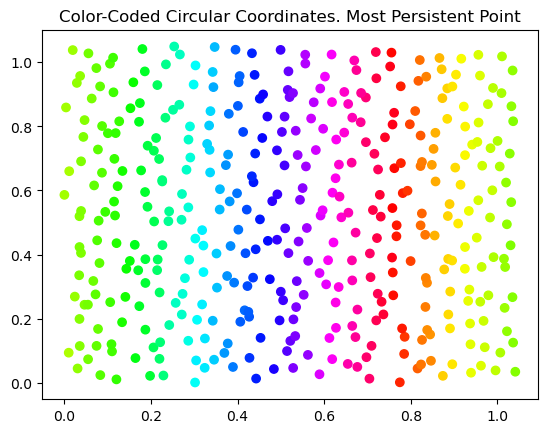

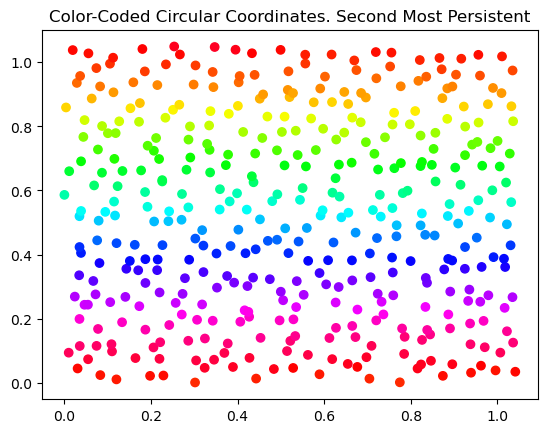

In [11]:
#SCATTER PLOT THE POINTS WITH COLOR-CODED CICRULAR COORDINATES

plt.scatter(X[:,0],X[:,1],c=circ_mp,cmap='hsv')
plt.title("Color-Coded Circular Coordinates. Most Persistent Point")
plt.savefig("Colored_Vertices.png")
plt.show()

plt.scatter(X[:,0],X[:,1],c=circ_smp,cmap='hsv')
plt.title("Color-Coded Circular Coordinates. Second Most Persistent")
plt.savefig("Colored_Vertices.png")
plt.show()

## Image Data

In [12]:
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

In [13]:
#ENTER PICTURE FOLDER

#CHANE THE DIRECTORY TO WHERE YOU HAVE THE PICTURES STORED
path = "/Users/georgesmyridis/Documents/Physics/Books-Notes/Graduate/Mathematics/Topological Data Analysis/Scripts/Homeworks 1/coil-20-unproc"
os.chdir(path)
img_list = os.listdir()

In [29]:
#SELECT OBJECT 
object_num = 1
img_name = "obj" + str(object_num) + "__0.png"
img = Image.open(img_name)
pix_imgs = np.array(img)
imgs = []; imgs.append(img)
img_names = []; img_names.append(img_name)
pix_imgs = pix_imgs.flatten()
for i in range(71):
    img_name = "obj" + str(object_num) + "__" + str(i+1) + ".png"
    img_names.append(img_name)
    img = Image.open(img_name)
    imgs.append(img)
    pix = np.array(img)
    pix = pix.flatten("C")
    pix_imgs = np.vstack((pix_imgs,pix))

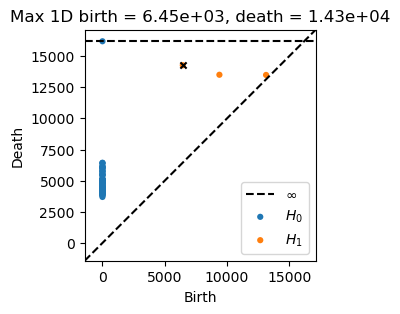

In [30]:
D = pairwise_distances(pix_imgs, metric = "euclidean")

result = ripser(D, coeff=41, do_cocycles=True, distance_matrix =True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

dgm1=diagrams[1]
idx=np.argmax(dgm1[:,1]-dgm1[:,0])

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.savefig("Persistence_Diagram_Images.png")
plt.show()

cocycle=cocycles[1][idx]
diagrams[1][idx];

In [31]:
thresh = 6.5e+03
circ = circular_coordinates(D,cocycle,thresh,41)

In [32]:
def poltocart(thetas):
    cart = []
    for i in range(thetas.shape[0]):
        cart.append([math.cos(2*math.pi*thetas[i]),math.sin(2*math.pi*thetas[i])])
    return np.array(cart)

In [33]:
cart = poltocart(circ)

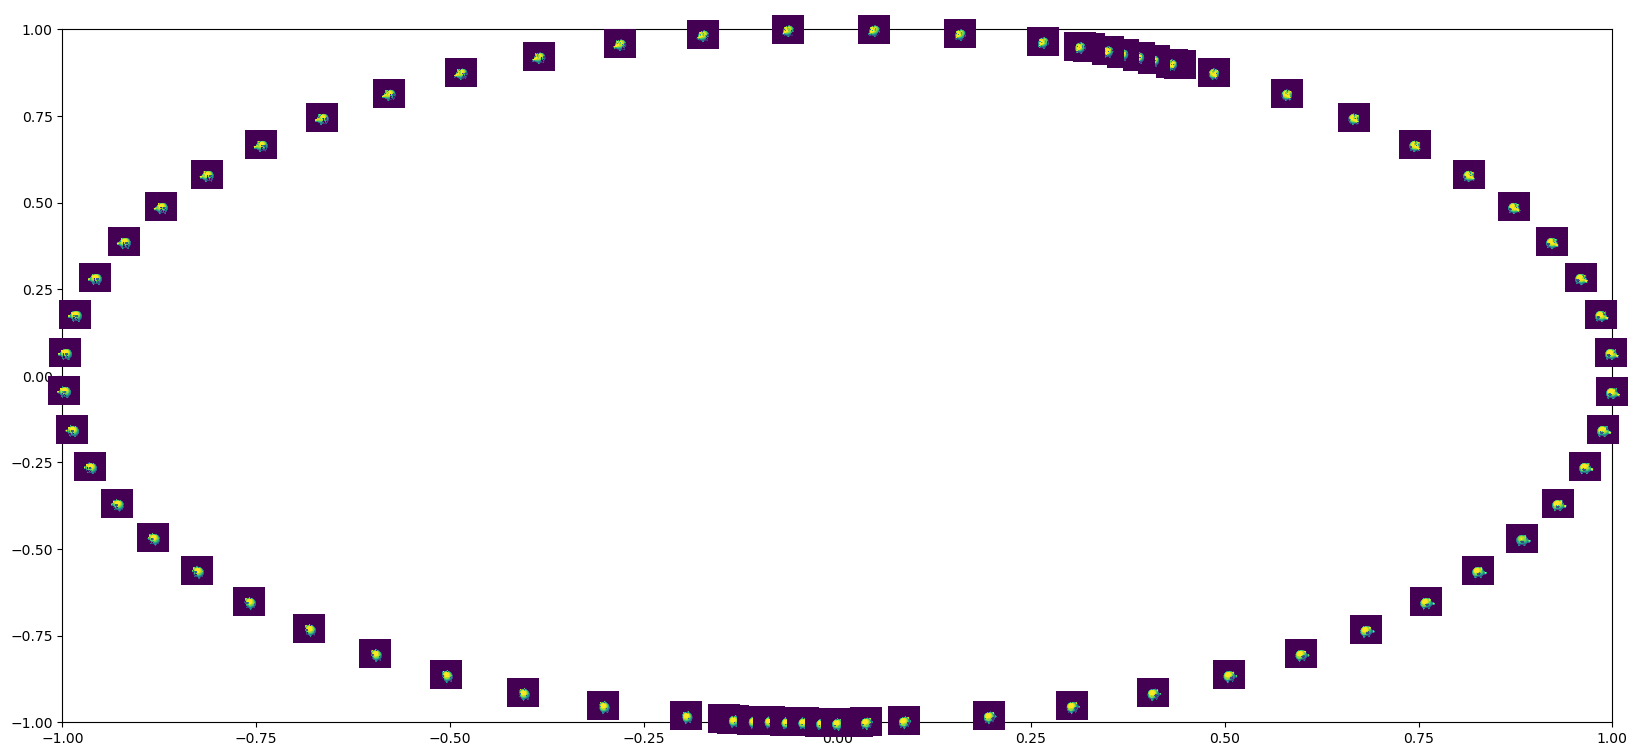

In [44]:
fig, ax = plt.subplots()
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.scatter(cart[:,0],cart[:,1]) 
plt.rcParams["figure.figsize"] = [20,9]
for x0, y0, path in zip(cart[:,0], cart[:,1],img_names):
    ab = AnnotationBbox(getImage(path,0.05), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [94]:
rest_objects = [1,2,3,4,5]
rest_objects.remove(object_num)

for j in rest_objects:
    for i in range(72):
        img_name = "obj" + str(j) + "__" + str(i) + ".png"
        img_names.append(img_name)
        img = Image.open(img_name)
        imgs.append(img)
        pix = np.array(img)
        pix = pix.flatten("C")
        pix_imgs = np.vstack((pix_imgs,pix))    

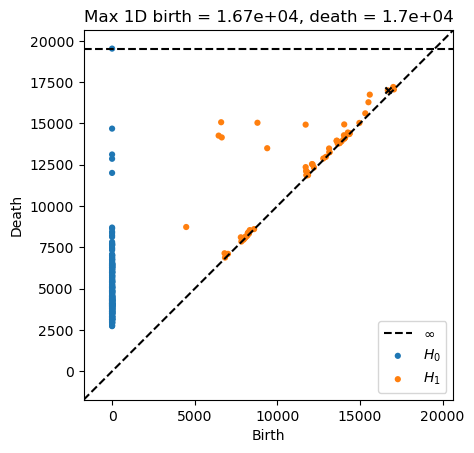

In [95]:
D = pairwise_distances(pix_imgs, metric = "euclidean")

result = ripser(D, coeff=41, do_cocycles=True, distance_matrix =True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.savefig("Persistence_Diagram_Images.png")
plt.show()


In [96]:
dgm1 = diagrams[1]
def diff_rat(array):
    return (array[:,1]-array[:,0])/array[:,0]

drat = diff_rat(dgm1).reshape((dgm1.shape[0],1))
indices = np.array(range(dgm1.shape[0])).reshape((dgm1.shape[0],1))
drat = np.hstack((indices,dgm1,drat))
drat = pd.DataFrame(drat, columns = ['Indices','Birth','Death','Diff_Ratios'])
drat = drat.sort_values(by = 'Diff_Ratios',ascending = False)
drat = drat.to_numpy()

idxs = np.array(drat[:,0][:5],dtype=np.int64)
drat[:,1:3][:5]

array([[ 6599.9453125 , 15071.60546875],
       [ 6448.41601562, 14262.19824219],
       [ 6636.35644531, 14152.17675781],
       [ 4485.39453125,  8731.47460938],
       [ 8797.41796875, 15039.8515625 ]])

As we can notice, there is no threshold such that all features are alive at the same time. So we have chosen such a threshold such that four of them are.

In [97]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pix_imgs)

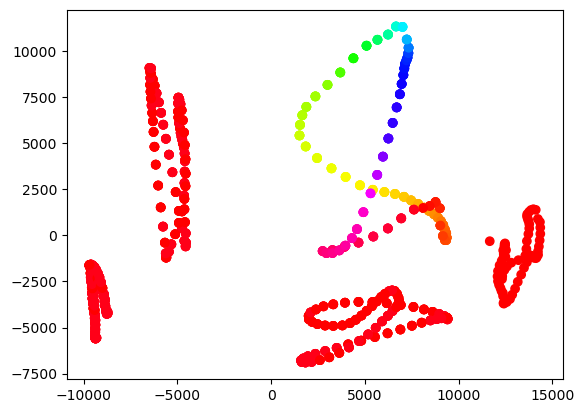

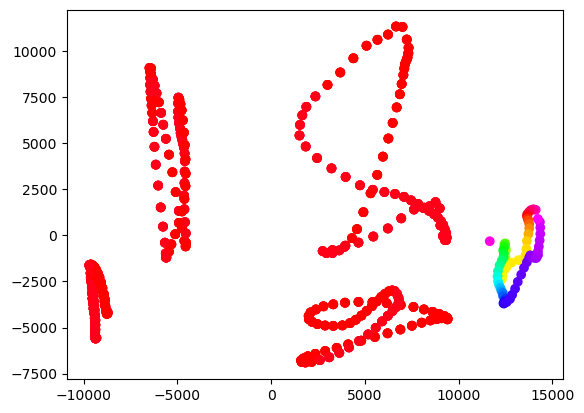

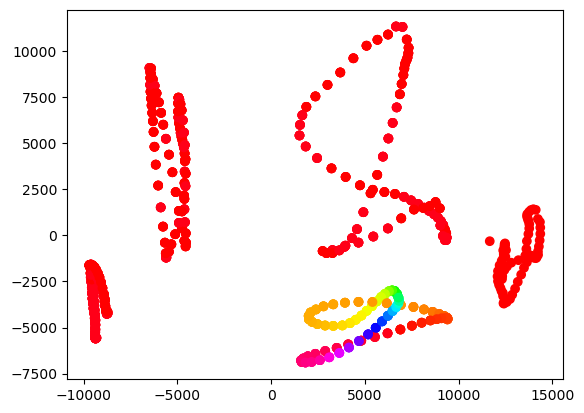

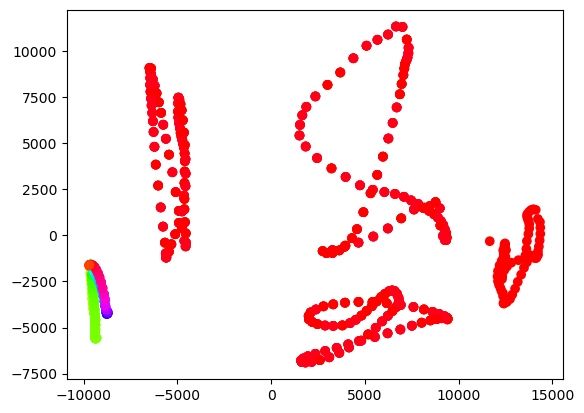

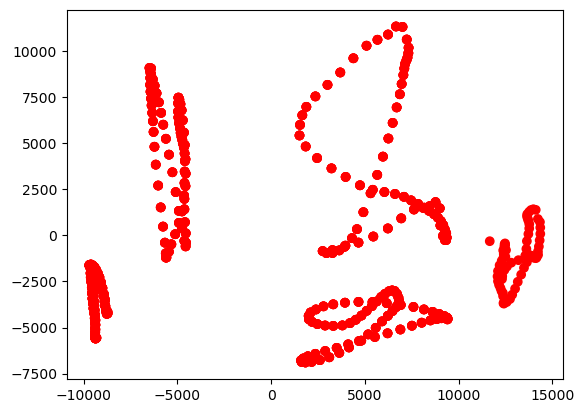

In [105]:
thresh = 7e+03
for i in idxs:
    cocycle = cocycles[1][i]
    circ = circular_coordinates(D,cocycle,thresh,41)
    plt.scatter(principalComponents[:,0],principalComponents[:,1],c=circ,cmap='hsv')
    plt.savefig("Images_PCA" + str(i) + ".png")
    plt.show()

## Surprise Me (15%)

NOTE! DO NOT RUN THE CODE, I HAVENT SENT THE PICTURES NOR THE VIDEO! If you want them please email me.

For this section, I downloaded a video from Youtube (https://www.youtube.com/watch?v=WYeFqSjvGaY), depicting the Earth rotating for about 30 seconds. Then I imported this video in Mathematica, and took 200 snapshots of the video at random times. Then I turned the picture from RGB to Grayscale and I increased the contrast. Then I imported the pictures into jupiter and applied the previous algorithm. The results are the following.

At first glance, it seems that the algorithm ideed works and shows the circular coordinates of the earth rotating. Even though the video is relatively pretty simple, it is remarkable to me that it does.

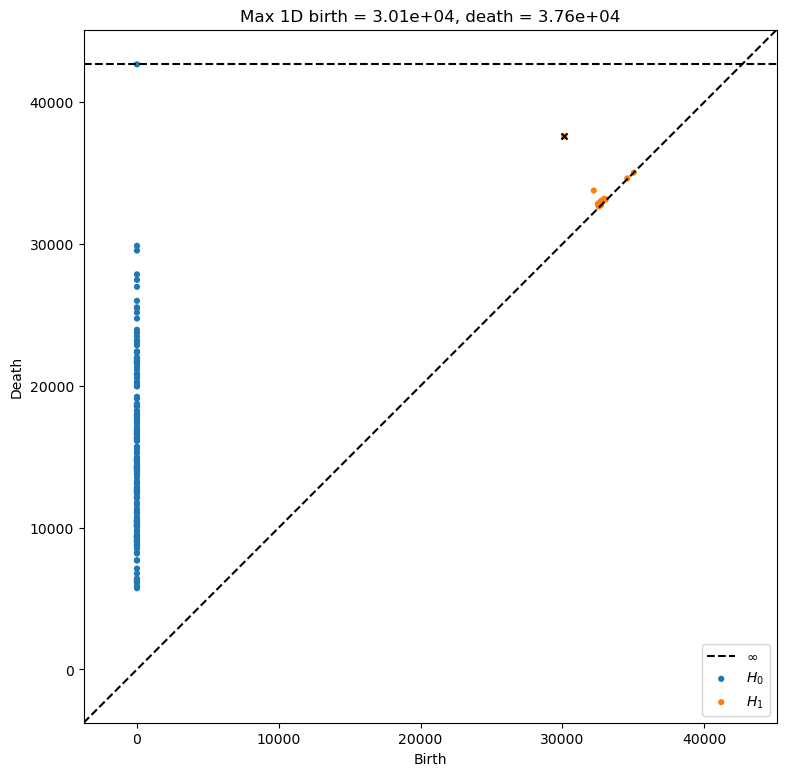

In [136]:
#SELECT OBJECT 
object_num = 1
img_name = "earth[" + str(object_num) + "].jpg"
img = Image.open(img_name)
pix_imgs = np.array(img)
imgs = []; imgs.append(img)
img_names = []; img_names.append(img_name)
pix_imgs = pix_imgs.flatten()
for i in range(199):
    img_name = "earth[" +  str(i+2) + "].jpg"
    img_names.append(img_name)
    img = Image.open(img_name)
    imgs.append(img)
    pix = np.array(img)
    pix = pix.flatten("C")
    pix_imgs = np.vstack((pix_imgs,pix))
    
D = pairwise_distances(pix_imgs, metric = "euclidean")

result = ripser(D, coeff=41, do_cocycles=True, distance_matrix =True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

dgm1=diagrams[1]
idx=np.argmax(dgm1[:,1]-dgm1[:,0])

plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.savefig("Persistence_Diagram_Images.png")
plt.show()

cocycle=cocycles[1][idx]
diagrams[1][idx];


thresh = 3.5e+04
circ = circular_coordinates(D,cocycle,thresh,41)
cart = poltocart(circ);

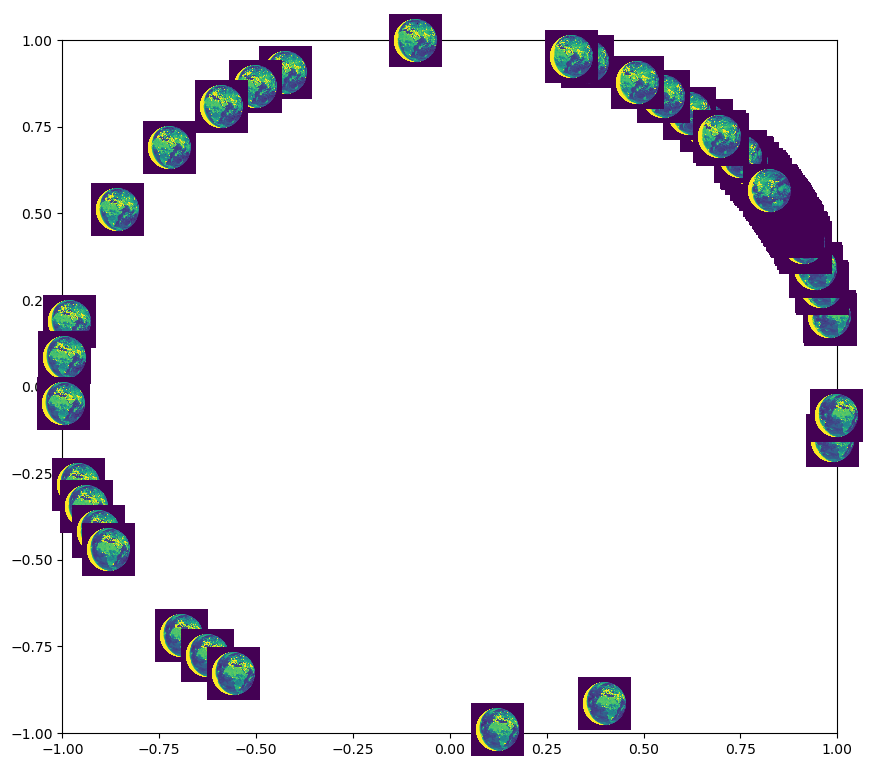

In [139]:
fig, ax = plt.subplots()
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.scatter(cart[:,0],cart[:,1]) 
plt.rcParams["figure.figsize"] = [20,9]
for x0, y0, path in zip(cart[:,0], cart[:,1],img_names):
    ab = AnnotationBbox(getImage(path,0.05), (x0, y0), frameon=False)
    ax.add_artist(ab)
    
## MAYBE RUN THIS CELL TWICE FOR BETTER FIGURE

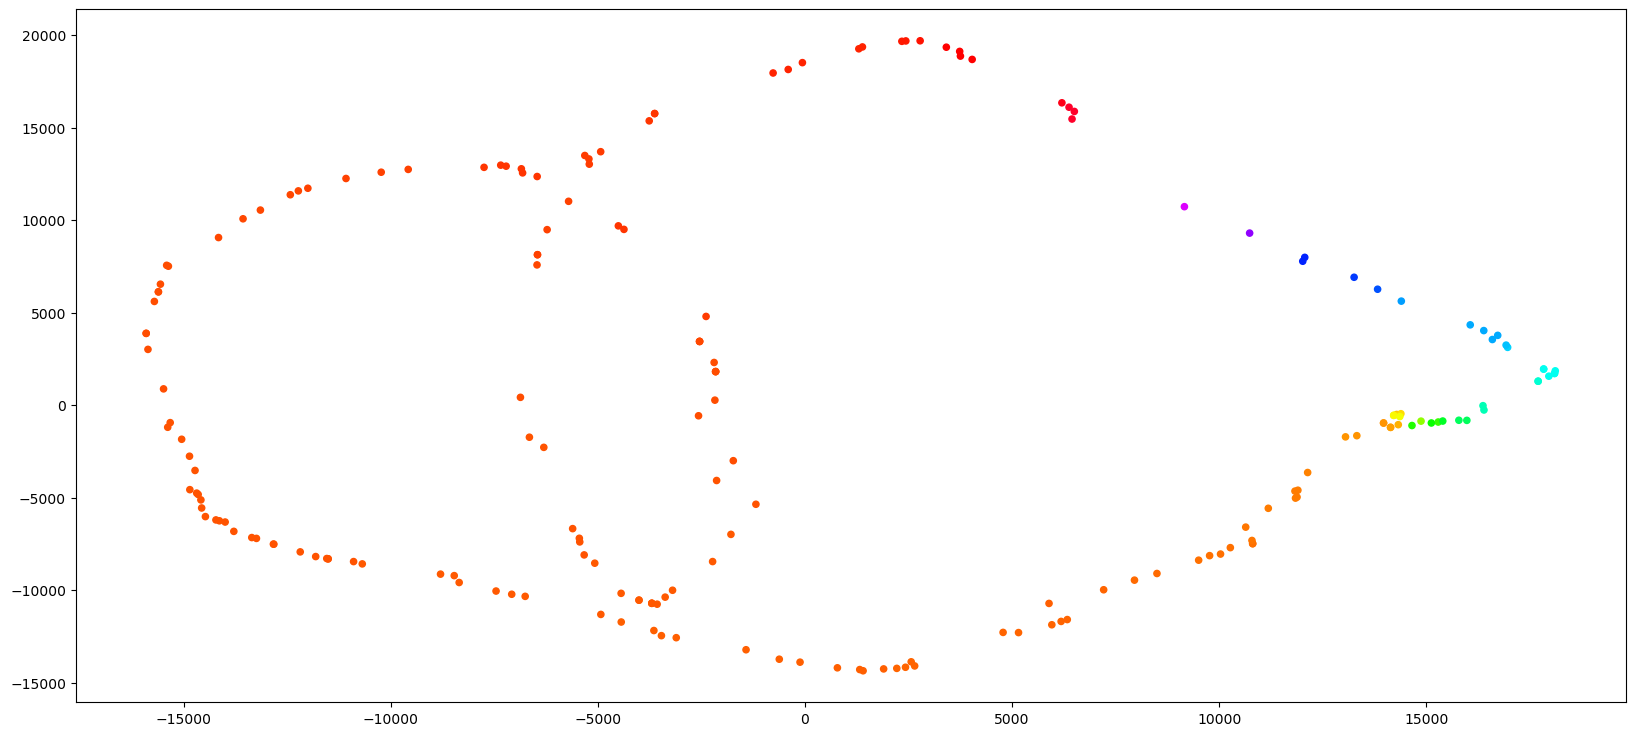

In [138]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pix_imgs)
plt.scatter(principalComponents[:,0],principalComponents[:,1],s=20,c=circ,cmap='hsv')
plt.rcParams["figure.figsize"] = [10,9]
plt.show()